# Summarization model

In [1]:

import torch
import torch.nn as nn

seed = 42
torch.manual_seed(seed)  # PyTorch CPU
torch.cuda.manual_seed(seed)  # PyTorch GPU
torch.cuda.manual_seed_all(seed)  # Multi-GPU

# Check if GPU is available
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"GPU count: {torch.cuda.device_count()}")
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
print(f"Using device: {device}")

# import os


PyTorch version: 2.6.0+cu126
CUDA available: True
CUDA version: 12.6
GPU count: 1
Using device: cuda


# Load dataset

In [2]:

from datasets import load_dataset

ds = load_dataset("argilla/cnn-dailymail-summaries", split='train', streaming=True)
print(ds)

IterableDataset({
    features: ['article', 'highlights', 'id', 'summary', 'distilabel_metadata', 'model_name'],
    num_shards: 7
})


# Get Tokenizer - BartTokenizer with 50265 vocab size

In [3]:
from transformers import BartTokenizer

tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
VOCAB_SIZE = tokenizer.vocab_size

SRC_MAX_SEQ = 512
TGT_MAX_SEQ = 64


# Prepare data

In [4]:
inputs = []
outputs = []
i = 0
max = 1000
for data in ds:
    article = tokenizer.encode(str(data['article']))
    summary = tokenizer.encode(str(data['highlights']))
    if len(article) <= SRC_MAX_SEQ and len(summary) <= TGT_MAX_SEQ:
        inputs.append(article)
        outputs.append(summary)
        i += 1
    
    if i == max:
        break

# Clean data

In [5]:
"""To set determined len for src and tgt --> also with pad tokens"""

# inputs = []
# outputs = []
# for i in range(len(articles)):
#     article = tokenizer.encode(str(articles[i]))
#     summary = tokenizer.encode(str(summaries[i]))
#     if len(article) <= SRC_MAX_SEQ and len(summary) <= TGT_MAX_SEQ:
#         inputs.append(article)
#         outputs.append(summary)

def clean_data(sentences, max_seq_length):
    for i, sentence in enumerate(sentences):
        if len(sentence) < max_seq_length:
            sentences[i] = sentence + [tokenizer.pad_token_id] * (max_seq_length - len(sentence))


clean_data(inputs, SRC_MAX_SEQ)
clean_data(outputs, TGT_MAX_SEQ)

In [6]:
articles_inputs = torch.tensor(inputs)
summaries_outputs = torch.tensor(outputs)
assert len(articles_inputs) == len(summaries_outputs), "Number of articles and summaries must be the same"
print('Max src seq len:', SRC_MAX_SEQ)
print('Max tgt seq len:', TGT_MAX_SEQ)
print('Number of examples:', len(inputs))
print("Number of vocab size:", VOCAB_SIZE)

Max src seq len: 512
Max tgt seq len: 64
Number of examples: 1000
Number of vocab size: 50265


# Custom Dataset and DataLoader with train and val data (80%, 20%)

In [7]:
from torch.utils.data import random_split, Dataset


class CustomDataset(Dataset):
    def __init__(self, inputs: torch.Tensor, outputs: torch.Tensor):
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]


dataset = CustomDataset(articles_inputs, summaries_outputs)
train_data, val_data = random_split(dataset, [0.8, 0.2])
print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(val_data)}")

Number of training samples: 800
Number of validation samples: 200


In [8]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32  # TODO: expand batch size for transformer architecture

train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    # drop_last=True
)

val_loader = DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    # drop_last=True
)

print(f"Number of batches in training set: {len(train_loader)}")
print(f"Number of batches in validation set: {len(val_loader)}")


Number of batches in training set: 25
Number of batches in validation set: 7


In [9]:
import math


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads 

        self.W_q = nn.Linear(d_model, d_model)  # Query transformation
        self.W_k = nn.Linear(d_model, d_model)  # Key transformation
        self.W_v = nn.Linear(d_model, d_model)  # Value transformation
        self.W_o = nn.Linear(d_model, d_model)  # Output transformation

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # TODO: use F..scaled_dot_product_attention
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

        attn_probs = torch.softmax(attn_scores, dim=-1)

        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [10]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        # Assumption: GELU outperforms ReLU which leads to 'ReLU dead neuron problem': https://arxiv.org/pdf/1606.08415
        self.gelu = nn.GELU(approximate='tanh')

    def forward(self, x):
        return self.fc2(self.gelu(self.fc1(x)))

In [11]:
"""NOTE: There is no evidence that positional encoding is better than simple learnable embeddings."""

#
# class PositionalEncoding(nn.Module):
#     def __init__(self, d_model, max_seq_length):
#         super(PositionalEncoding, self).__init__()
#
#         pe = torch.zeros(max_seq_length, d_model)
#         position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
#
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#
#         self.register_buffer('pe', pe.unsqueeze(0))
#
#     def forward(self, x):
#         return x + self.pe[:, :x.size(1)]

'NOTE: There is no evidence that positional encoding is better than simple learnable embeddings.'

In [12]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)  # TODO: one dropout layer or two?

    def forward(self, x, mask):
        # Normalization before sub-blocks: as described at: https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf
        residual_x = self.norm1(x)  # residual_x described at: https://arxiv.org/pdf/1904.10509
        attn_output = self.self_attn(residual_x, residual_x, residual_x, mask)
        x = x + self.dropout(attn_output)
        residual_x = self.norm2(x)  # Normalization before sub-blocks
        ff_output = self.feed_forward(residual_x)
        x = x + self.dropout(ff_output)
        return x

In [13]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        # Normalization before sub-blocks: as described at: https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf
        residual_x = self.norm1(x)
        attn_output = self.self_attn(residual_x, residual_x, residual_x, tgt_mask)
        x = x + self.dropout(attn_output)
        residual_x = self.norm2(x)  # Normalization before sub-blocks
        attn_output = self.cross_attn(residual_x, enc_output, enc_output, src_mask)
        x = x + self.dropout(attn_output)
        residual_x = self.norm3(x)  # Normalization before sub-blocks
        ff_output = self.feed_forward(residual_x)
        x = x + self.dropout(ff_output)
        return x

In [14]:



class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_src_seq_len,
                 max_tgt_seq_len, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        # self.src_positional_encoding = PositionalEncoding(d_model, max_src_seq_len)
        # self.tgt_positional_encoding = PositionalEncoding(d_model, max_tgt_seq_len)
        self.src_positional_encoding = nn.Embedding(max_src_seq_len,
                                                    d_model)  # instead of cos and sin functions (in PositionalEncoding)
        self.tgt_positional_encoding = nn.Embedding(max_tgt_seq_len, d_model)

        self.encoder_layers = nn.ModuleList(
            [EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList(
            [DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        # One more LayerNorm as described: https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf
        self.ln_f = nn.LayerNorm(d_model)
        self.output_layer = nn.Linear(d_model, tgt_vocab_size,
                                      bias=False)  # bias=False as depicted: https://github.com/karpathy/nanoGPT/blob/master/model.py
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != tokenizer.pad_token_id).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != tokenizer.pad_token_id).unsqueeze(1).unsqueeze(3)
        src_mask, tgt_mask = src_mask.to(device), tgt_mask.to(device)
        seq_length = tgt.size(1)
        casual_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        casual_mask = casual_mask.to(device)
        tgt_mask = tgt_mask & casual_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        # src_embedded = self.dropout(self.src_positional_encoding(self.encoder_embedding(src)))
        # tgt_embedded = self.dropout(self.tgt_positional_encoding(self.decoder_embedding(tgt)))

        src_pos = torch.arange(0, src.size(1)).to(device)  # [0, 1, 2 ... src.size(1)]
        src_pos = self.src_positional_encoding(src_pos)
        src_embedded = self.encoder_embedding(src)
        src_embedded = self.dropout(src_pos + src_embedded)

        tgt_pos = torch.arange(0, tgt.size(1)).to(device)
        tgt_pos = self.tgt_positional_encoding(tgt_pos)
        tgt_embedded = self.decoder_embedding(tgt)
        tgt_embedded = self.dropout(tgt_pos + tgt_embedded)

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        # One more LayerNorm as described: https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf
        dec_output = self.ln_f(dec_output)
        output = self.output_layer(dec_output)
        return output

In [15]:
src_vocab_size = VOCAB_SIZE
tgt_vocab_size = VOCAB_SIZE
d_model = 128  # TODO: experiment with model complexity - it can lead to overfitting
num_heads = 8
num_layers = 6  # TODO: how many layers? as above, model complexity; smaller BART uses 6: https://arxiv.org/pdf/1910.13461
d_ff = d_model * 4
max_src_seq_len = SRC_MAX_SEQ
max_tgt_seq_len = TGT_MAX_SEQ
dropout = 0.1

In [16]:
transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_src_seq_len,
                          max_tgt_seq_len,
                          dropout)
transformer.to(device)
num_parameters = sum(p.numel() for p in transformer.parameters())
print(f"Number of parameters: {num_parameters/1000000} M")


Number of parameters: 22.152832 M


# Train model

In [24]:
import torch
import torch.nn.functional as F
from transformers import get_linear_schedule_with_warmup
from torch import optim
from tqdm import tqdm

torch.manual_seed(seed) 
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

lr = 0.001
optimizer = optim.Adam(
    transformer.parameters(), lr=lr, betas=(0.9, 0.95), eps=1e-8, weight_decay=0.0001
)

# TODO: experiment with gradient accumulation
num_epochs = 100
# TODO: add warmup steps
num_training_steps = len(train_loader) * num_epochs
num_warmup_steps = int(0.1 * num_training_steps) # TODO: experiment with that

scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
)

# Tracking history
lr_history = []
loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    transformer.train()

    # Progress bar for training
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}")

    for step, (src_data, tgt_data) in enumerate(progress_bar):
        src_data, tgt_data = src_data.to(device), tgt_data.to(device)

        # Forward pass
        output = transformer(src_data, tgt_data[:, :-1])

        # Compute loss
        loss = F.cross_entropy(
            output.contiguous().view(-1, tgt_vocab_size),
            tgt_data[:, 1:].contiguous().view(-1),
            ignore_index=tokenizer.pad_token_id
        )

        # Track loss
        loss_history.append(loss.item())
        epoch_loss += loss.item()
        lr_history.append(optimizer.param_groups[0]["lr"])

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(transformer.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({"Batch Loss": loss.item()})

    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"Epoch: {epoch + 1}, Loss: {avg_epoch_loss:.4f}")

    transformer.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for val_src_data, val_tgt_data in val_loader:
            val_src_data, val_tgt_data = val_src_data.to(device), val_tgt_data.to(device)

            # Forward pass
            val_output = transformer(val_src_data, val_tgt_data[:, :-1])

            val_loss = F.cross_entropy(
                val_output.contiguous().view(-1, tgt_vocab_size),
                val_tgt_data[:, 1:].contiguous().view(-1),
                ignore_index=tokenizer.pad_token_id
            )

            total_val_loss += val_loss.item()

    # Calculate average validation loss
    avg_val_loss = total_val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)
    print(f"Average Validation Loss: {avg_val_loss:.4f}")


Epoch 1: 100%|██████████| 25/25 [00:04<00:00,  5.65it/s, Batch Loss=6.44]


Epoch: 1, Loss: 6.3525
Average Validation Loss: 7.0526


Epoch 2: 100%|██████████| 25/25 [00:04<00:00,  5.98it/s, Batch Loss=6.34]


Epoch: 2, Loss: 6.3356
Average Validation Loss: 7.0475


Epoch 3: 100%|██████████| 25/25 [00:04<00:00,  5.98it/s, Batch Loss=6.24]


Epoch: 3, Loss: 6.2889
Average Validation Loss: 7.0808


Epoch 4: 100%|██████████| 25/25 [00:04<00:00,  5.98it/s, Batch Loss=6.23]


Epoch: 4, Loss: 6.2189
Average Validation Loss: 7.0052


Epoch 5: 100%|██████████| 25/25 [00:04<00:00,  6.02it/s, Batch Loss=6.07]


Epoch: 5, Loss: 6.1290
Average Validation Loss: 7.0335


Epoch 6: 100%|██████████| 25/25 [00:04<00:00,  5.99it/s, Batch Loss=6.04]


Epoch: 6, Loss: 6.0192
Average Validation Loss: 6.9212


Epoch 7: 100%|██████████| 25/25 [00:04<00:00,  6.01it/s, Batch Loss=6.11]


Epoch: 7, Loss: 5.8960
Average Validation Loss: 6.9290


Epoch 8: 100%|██████████| 25/25 [00:04<00:00,  5.99it/s, Batch Loss=5.65]


Epoch: 8, Loss: 5.7507
Average Validation Loss: 6.9042


Epoch 9: 100%|██████████| 25/25 [00:04<00:00,  5.99it/s, Batch Loss=5.69]


Epoch: 9, Loss: 5.5849
Average Validation Loss: 6.8235


Epoch 10: 100%|██████████| 25/25 [00:04<00:00,  5.99it/s, Batch Loss=5.56]


Epoch: 10, Loss: 5.4054
Average Validation Loss: 6.7624


Epoch 11: 100%|██████████| 25/25 [00:04<00:00,  5.99it/s, Batch Loss=5.26]


Epoch: 11, Loss: 5.2047
Average Validation Loss: 6.7783


Epoch 12: 100%|██████████| 25/25 [00:04<00:00,  6.00it/s, Batch Loss=4.97]


Epoch: 12, Loss: 4.9855
Average Validation Loss: 6.7762


Epoch 13: 100%|██████████| 25/25 [00:04<00:00,  5.99it/s, Batch Loss=4.89]


Epoch: 13, Loss: 4.7724
Average Validation Loss: 6.7231


Epoch 14: 100%|██████████| 25/25 [00:04<00:00,  6.00it/s, Batch Loss=4.36]


Epoch: 14, Loss: 4.5546
Average Validation Loss: 6.7373


Epoch 15: 100%|██████████| 25/25 [00:04<00:00,  6.01it/s, Batch Loss=4.31]


Epoch: 15, Loss: 4.3525
Average Validation Loss: 6.7160


Epoch 16: 100%|██████████| 25/25 [00:04<00:00,  5.99it/s, Batch Loss=4.18]


Epoch: 16, Loss: 4.1488
Average Validation Loss: 6.6720


Epoch 17: 100%|██████████| 25/25 [00:04<00:00,  5.99it/s, Batch Loss=3.82]


Epoch: 17, Loss: 3.9437
Average Validation Loss: 6.7007


Epoch 18: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=3.92]


Epoch: 18, Loss: 3.7424
Average Validation Loss: 6.6934


Epoch 19: 100%|██████████| 25/25 [00:04<00:00,  6.01it/s, Batch Loss=3.75]


Epoch: 19, Loss: 3.5551
Average Validation Loss: 6.7327


Epoch 20: 100%|██████████| 25/25 [00:04<00:00,  5.99it/s, Batch Loss=3.6] 


Epoch: 20, Loss: 3.3685
Average Validation Loss: 6.6519


Epoch 21: 100%|██████████| 25/25 [00:04<00:00,  5.99it/s, Batch Loss=3.34]


Epoch: 21, Loss: 3.1970
Average Validation Loss: 6.6707


Epoch 22: 100%|██████████| 25/25 [00:04<00:00,  5.99it/s, Batch Loss=2.93]


Epoch: 22, Loss: 3.0328
Average Validation Loss: 6.8593


Epoch 23: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=2.91]


Epoch: 23, Loss: 2.8646
Average Validation Loss: 6.7552


Epoch 24: 100%|██████████| 25/25 [00:04<00:00,  5.99it/s, Batch Loss=2.77]


Epoch: 24, Loss: 2.7106
Average Validation Loss: 6.7921


Epoch 25: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=2.76]


Epoch: 25, Loss: 2.5523
Average Validation Loss: 6.7822


Epoch 26: 100%|██████████| 25/25 [00:04<00:00,  5.99it/s, Batch Loss=2.33]


Epoch: 26, Loss: 2.4096
Average Validation Loss: 6.9228


Epoch 27: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=2.27]


Epoch: 27, Loss: 2.2798
Average Validation Loss: 6.8501


Epoch 28: 100%|██████████| 25/25 [00:04<00:00,  5.95it/s, Batch Loss=2.29]


Epoch: 28, Loss: 2.1515
Average Validation Loss: 6.8722


Epoch 29: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=2.02]


Epoch: 29, Loss: 2.0338
Average Validation Loss: 6.8544


Epoch 30: 100%|██████████| 25/25 [00:04<00:00,  6.01it/s, Batch Loss=1.88]


Epoch: 30, Loss: 1.9109
Average Validation Loss: 7.0347


Epoch 31: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=1.77]


Epoch: 31, Loss: 1.8063
Average Validation Loss: 6.9947


Epoch 32: 100%|██████████| 25/25 [00:04<00:00,  5.98it/s, Batch Loss=1.82]


Epoch: 32, Loss: 1.7066
Average Validation Loss: 7.0332


Epoch 33: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=1.73]


Epoch: 33, Loss: 1.6116
Average Validation Loss: 7.1690


Epoch 34: 100%|██████████| 25/25 [00:04<00:00,  5.99it/s, Batch Loss=1.67]


Epoch: 34, Loss: 1.5206
Average Validation Loss: 7.1785


Epoch 35: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=1.53]


Epoch: 35, Loss: 1.4287
Average Validation Loss: 7.2623


Epoch 36: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=1.36]


Epoch: 36, Loss: 1.3559
Average Validation Loss: 7.2185


Epoch 37: 100%|██████████| 25/25 [00:04<00:00,  5.99it/s, Batch Loss=1.26]


Epoch: 37, Loss: 1.2857
Average Validation Loss: 7.2636


Epoch 38: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=1.28]


Epoch: 38, Loss: 1.2261
Average Validation Loss: 7.4146


Epoch 39: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=1.24] 


Epoch: 39, Loss: 1.1528
Average Validation Loss: 7.2896


Epoch 40: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=1.1] 


Epoch: 40, Loss: 1.0925
Average Validation Loss: 7.4036


Epoch 41: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=1.08] 


Epoch: 41, Loss: 1.0396
Average Validation Loss: 7.2893


Epoch 42: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=1.02] 


Epoch: 42, Loss: 0.9961
Average Validation Loss: 7.2365


Epoch 43: 100%|██████████| 25/25 [00:04<00:00,  5.99it/s, Batch Loss=1.03] 


Epoch: 43, Loss: 0.9407
Average Validation Loss: 7.4853


Epoch 44: 100%|██████████| 25/25 [00:04<00:00,  5.96it/s, Batch Loss=1.02] 


Epoch: 44, Loss: 0.9013
Average Validation Loss: 7.5804


Epoch 45: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=0.955]


Epoch: 45, Loss: 0.8628
Average Validation Loss: 7.3883


Epoch 46: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=0.865]


Epoch: 46, Loss: 0.8238
Average Validation Loss: 7.5600


Epoch 47: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=0.842]


Epoch: 47, Loss: 0.7826
Average Validation Loss: 7.5488


Epoch 48: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=0.883]


Epoch: 48, Loss: 0.7544
Average Validation Loss: 7.7435


Epoch 49: 100%|██████████| 25/25 [00:04<00:00,  5.96it/s, Batch Loss=0.761]


Epoch: 49, Loss: 0.7253
Average Validation Loss: 7.6393


Epoch 50: 100%|██████████| 25/25 [00:04<00:00,  5.95it/s, Batch Loss=0.747]


Epoch: 50, Loss: 0.6933
Average Validation Loss: 7.6840


Epoch 51: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=0.704]


Epoch: 51, Loss: 0.6657
Average Validation Loss: 7.6238


Epoch 52: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=0.736]


Epoch: 52, Loss: 0.6487
Average Validation Loss: 7.4601


Epoch 53: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=0.695]


Epoch: 53, Loss: 0.6202
Average Validation Loss: 7.6539


Epoch 54: 100%|██████████| 25/25 [00:04<00:00,  5.94it/s, Batch Loss=0.569]


Epoch: 54, Loss: 0.6065
Average Validation Loss: 7.7072


Epoch 55: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=0.673]


Epoch: 55, Loss: 0.5812
Average Validation Loss: 7.9493


Epoch 56: 100%|██████████| 25/25 [00:04<00:00,  5.99it/s, Batch Loss=0.603]


Epoch: 56, Loss: 0.5546
Average Validation Loss: 7.9876


Epoch 57: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=0.609]


Epoch: 57, Loss: 0.5398
Average Validation Loss: 7.8430


Epoch 58: 100%|██████████| 25/25 [00:04<00:00,  5.99it/s, Batch Loss=0.61] 


Epoch: 58, Loss: 0.5275
Average Validation Loss: 7.8496


Epoch 59: 100%|██████████| 25/25 [00:04<00:00,  5.99it/s, Batch Loss=0.555]


Epoch: 59, Loss: 0.5093
Average Validation Loss: 7.8870


Epoch 60: 100%|██████████| 25/25 [00:04<00:00,  5.95it/s, Batch Loss=0.496]


Epoch: 60, Loss: 0.4928
Average Validation Loss: 7.8244


Epoch 61: 100%|██████████| 25/25 [00:04<00:00,  6.02it/s, Batch Loss=0.482]


Epoch: 61, Loss: 0.4804
Average Validation Loss: 7.8941


Epoch 62: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=0.493]


Epoch: 62, Loss: 0.4635
Average Validation Loss: 8.0227


Epoch 63: 100%|██████████| 25/25 [00:04<00:00,  5.96it/s, Batch Loss=0.469]


Epoch: 63, Loss: 0.4512
Average Validation Loss: 7.9791


Epoch 64: 100%|██████████| 25/25 [00:04<00:00,  5.91it/s, Batch Loss=0.478]


Epoch: 64, Loss: 0.4439
Average Validation Loss: 7.6961


Epoch 65: 100%|██████████| 25/25 [00:04<00:00,  5.96it/s, Batch Loss=0.477]


Epoch: 65, Loss: 0.4319
Average Validation Loss: 7.7562


Epoch 66: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=0.46] 


Epoch: 66, Loss: 0.4193
Average Validation Loss: 7.9754


Epoch 67: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=0.46] 


Epoch: 67, Loss: 0.4074
Average Validation Loss: 8.0965


Epoch 68: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=0.404]


Epoch: 68, Loss: 0.3955
Average Validation Loss: 7.7808


Epoch 69: 100%|██████████| 25/25 [00:04<00:00,  5.95it/s, Batch Loss=0.385]


Epoch: 69, Loss: 0.3863
Average Validation Loss: 8.0041


Epoch 70: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=0.382]


Epoch: 70, Loss: 0.3790
Average Validation Loss: 8.1798


Epoch 71: 100%|██████████| 25/25 [00:04<00:00,  5.95it/s, Batch Loss=0.392]


Epoch: 71, Loss: 0.3657
Average Validation Loss: 7.8960


Epoch 72: 100%|██████████| 25/25 [00:04<00:00,  5.99it/s, Batch Loss=0.357]


Epoch: 72, Loss: 0.3595
Average Validation Loss: 8.0675


Epoch 73: 100%|██████████| 25/25 [00:04<00:00,  5.99it/s, Batch Loss=0.388]


Epoch: 73, Loss: 0.3508
Average Validation Loss: 7.8456


Epoch 74: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=0.351]


Epoch: 74, Loss: 0.3462
Average Validation Loss: 8.2029


Epoch 75: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=0.354]


Epoch: 75, Loss: 0.3345
Average Validation Loss: 7.7703


Epoch 76: 100%|██████████| 25/25 [00:04<00:00,  5.99it/s, Batch Loss=0.314]


Epoch: 76, Loss: 0.3258
Average Validation Loss: 8.2730


Epoch 77: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=0.338]


Epoch: 77, Loss: 0.3254
Average Validation Loss: 8.0720


Epoch 78: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=0.337]


Epoch: 78, Loss: 0.3200
Average Validation Loss: 8.0892


Epoch 79: 100%|██████████| 25/25 [00:04<00:00,  5.99it/s, Batch Loss=0.325]


Epoch: 79, Loss: 0.3097
Average Validation Loss: 8.1867


Epoch 80: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=0.293]


Epoch: 80, Loss: 0.2983
Average Validation Loss: 7.9755


Epoch 81: 100%|██████████| 25/25 [00:04<00:00,  5.99it/s, Batch Loss=0.326]


Epoch: 81, Loss: 0.2951
Average Validation Loss: 8.0490


Epoch 82: 100%|██████████| 25/25 [00:04<00:00,  5.99it/s, Batch Loss=0.307]


Epoch: 82, Loss: 0.2917
Average Validation Loss: 7.9909


Epoch 83: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=0.325]


Epoch: 83, Loss: 0.2867
Average Validation Loss: 8.2489


Epoch 84: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=0.305]


Epoch: 84, Loss: 0.2767
Average Validation Loss: 8.0151


Epoch 85: 100%|██████████| 25/25 [00:04<00:00,  5.99it/s, Batch Loss=0.29] 


Epoch: 85, Loss: 0.2762
Average Validation Loss: 8.2125


Epoch 86: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=0.254]


Epoch: 86, Loss: 0.2705
Average Validation Loss: 8.2022


Epoch 87: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=0.284]


Epoch: 87, Loss: 0.2663
Average Validation Loss: 8.2296


Epoch 88: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=0.278]


Epoch: 88, Loss: 0.2606
Average Validation Loss: 8.3285


Epoch 89: 100%|██████████| 25/25 [00:04<00:00,  5.99it/s, Batch Loss=0.281]


Epoch: 89, Loss: 0.2551
Average Validation Loss: 8.2701


Epoch 90: 100%|██████████| 25/25 [00:04<00:00,  5.99it/s, Batch Loss=0.244]


Epoch: 90, Loss: 0.2542
Average Validation Loss: 8.0313


Epoch 91: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=0.251]


Epoch: 91, Loss: 0.2475
Average Validation Loss: 8.2629


Epoch 92: 100%|██████████| 25/25 [00:04<00:00,  5.99it/s, Batch Loss=0.237]


Epoch: 92, Loss: 0.2417
Average Validation Loss: 8.0842


Epoch 93: 100%|██████████| 25/25 [00:04<00:00,  5.99it/s, Batch Loss=0.201]


Epoch: 93, Loss: 0.2443
Average Validation Loss: 7.9972


Epoch 94: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=0.268]


Epoch: 94, Loss: 0.2367
Average Validation Loss: 8.0685


Epoch 95: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=0.219]


Epoch: 95, Loss: 0.2356
Average Validation Loss: 7.9677


Epoch 96: 100%|██████████| 25/25 [00:04<00:00,  6.01it/s, Batch Loss=0.229]


Epoch: 96, Loss: 0.2324
Average Validation Loss: 8.1015


Epoch 97: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=0.244]


Epoch: 97, Loss: 0.2282
Average Validation Loss: 8.2368


Epoch 98: 100%|██████████| 25/25 [00:04<00:00,  5.99it/s, Batch Loss=0.223]


Epoch: 98, Loss: 0.2247
Average Validation Loss: 8.3406


Epoch 99: 100%|██████████| 25/25 [00:04<00:00,  5.99it/s, Batch Loss=0.228]


Epoch: 99, Loss: 0.2247
Average Validation Loss: 8.2250


Epoch 100: 100%|██████████| 25/25 [00:04<00:00,  5.97it/s, Batch Loss=0.245]


Epoch: 100, Loss: 0.2262
Average Validation Loss: 8.2205


In [18]:
# import gc
# del transformer
# gc.collect()

# Show charts with lr and loss

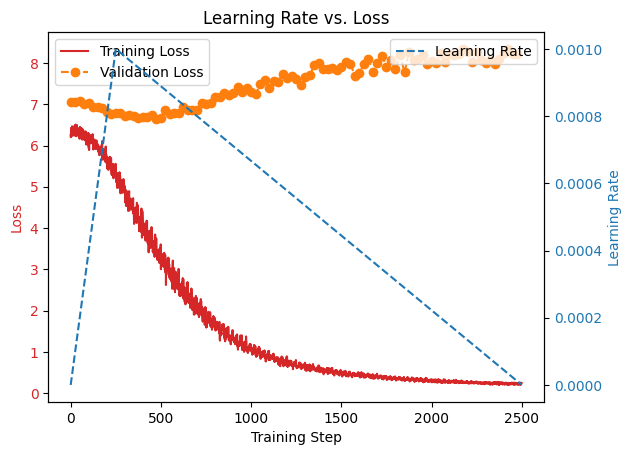

In [25]:
from matplotlib import pyplot as plt

# Ensure all histories are properly formatted
assert len(lr_history) == len(
    loss_history
), "Length of lr_history and loss_history must be the same"

# Create figure and primary y-axis for Loss
fig, ax1 = plt.subplots()

ax1.set_title("Learning Rate vs. Loss")
ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss", color="tab:red")
ax1.plot(range(len(loss_history)), loss_history, color="tab:red", label="Training Loss")
ax1.tick_params(axis="y", labelcolor="tab:red")

# Plot validation loss (assuming it occurs every 'epoch_interval' steps)
epoch_interval = len(loss_history) // len(val_loss_history)
val_x = [
    i * epoch_interval for i in range(len(val_loss_history))
]  # X values for validation loss
ax1.plot(
    val_x,
    val_loss_history,
    color="tab:orange",
    marker="o",
    linestyle="dashed",
    label="Validation Loss",
)

# Create secondary y-axis for Learning Rate
ax2 = ax1.twinx()
ax2.set_ylabel("Learning Rate", color="tab:blue")
ax2.plot(
    range(len(lr_history)),
    lr_history,
    color="tab:blue",
    linestyle="--",
    label="Learning Rate",
)
ax2.tick_params(axis="y", labelcolor="tab:blue")

# Legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()

# Model inference

In [87]:
def generate_summary(sentence, tokenizer, model, max_length=TGT_MAX_SEQ):
    """
    Translates a single Polish sentence into Ukrainian using greedy decoding.
    """
    model.eval()  # Set the model to evaluation mode

    tokens = tokenizer.encode(sentence)
    tokens = torch.tensor(tokens).unsqueeze(0).to(device)  # Shape: (1, seq_len)
    # print(tokens)

    # Start with the input sentence and an empty target sequence
    src_data = tokens
    tgt_data = torch.tensor([tokenizer.bos_token_id]).unsqueeze(0).to(device)

    with torch.no_grad():
        for _ in range(max_length):
            output = model(src_data, tgt_data)

            next_token_id = output[:, -1, :].argmax(dim=-1).item()

            tgt_data = torch.cat([tgt_data, torch.tensor([[next_token_id]]).to(device)], dim=1)

            if next_token_id == tokenizer.eos_token_id:
                break

    # Decode the token ids back to the sentence
    translated_tokens = tgt_data.squeeze().tolist()
    translated_sentence = tokenizer.decode(translated_tokens, skip_special_tokens=True)

    return translated_sentence


def inference_from_datasets(train_dataset: bool = True, index: int = 0) -> (str, str):
    if train_dataset:
        dataset = train_loader.dataset
    else:
        dataset = val_loader.dataset
    article = tokenizer.decode(dataset[index][0].tolist(), skip_special_tokens=True)
    translation = generate_summary(article, tokenizer, transformer)

    print('Dataset:', 'Train' if train_dataset else 'Validation')
    print('Article:', article[:200])
    print('Generated translation:', translation)
    real_translation = tokenizer.decode(dataset[index][1].tolist(), skip_special_tokens=True)
    print('Real translation:', real_translation)
    return translation, real_translation


generated_summary, real_summary = inference_from_datasets(train_dataset=True, index=0)

Dataset: Train
Article: More than 1,000 people rallied Sunday in support of Israel in front of the Israeli Embassy in the Spanish capital. Spaniards protest Sunday in support of Israel's military action in Gaza. The rally ca
Generated translation: Census-takers fan out across Sudan this week in a landmark headcount .
Count will be used to determine how power is shared in the war-torn country .
North-south tensions continue to simmer, threatening the return of civil war .
Real translation: Pro-Israel crowd rallies in front of Israeli Embassy in Madrid .
Demo follows pro-Palestian gathering last weekend attended by ruling lawmakers .
Spain has earmarked euros 6.5M ($8.5M) in humanitarian aid to Gaza .


# ROUGE metrics

In [ ]:
# proper values: https://klu.ai/glossary/rouge-score
# ROUGE-1 >0.5; could be 0.4-0.5
# ROUGE-2 >0.4; could be 0.2-0.4
# ROUGE-L ~0.4; could be 0.3-04
import evaluate
rouge = evaluate.load("rouge")
if len(generated_summary) > len(real_summary):
    generated_summary = generated_summary[:len(real_summary)]
else:
    real_summary = real_summary[:len(generated_summary)]


assert len(generated_summary) == len(real_summary)
generated_summary = [generated_summary]
real_summary = [real_summary]

results = rouge.compute(predictions=generated_summary, references=real_summary)

print('ROUGE-1', f"{results['rouge1']:.3f}")
print('ROUGE-2', f"{results['rouge2']:.3f}")
print('ROUGE-L', f"{results['rougeL']:.3f}")

ROUGE-1 0.083
ROUGE-2 0.000
ROUGE-L 0.083


In [22]:
# PATH = r"my_model_translation.pt"
# torch.save(transformer.state_dict(), PATH)

In [23]:
# next_model = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_src_seq_len,
#                          max_tgt_seq_len, dropout)
# next_model.load_state_dict(torch.load(PATH, weights_only=True))
# next_model = next_model.to(device)
# # print(next_model)
#
# # sentence = tokenizer.decode(train_loader.dataset[0][0].tolist(), skip_special_tokens=True)
# sentence = "What are light beans there?"
# print(sentence)
# # sentence = "Prehistoric humans studied the relationship between the seasons and the length of days to plan their hunting and gathering activities."
# translation = translate_sentence(sentence, tokenizer, next_model)
# print(translation)